# **Explainable Artificial Intelligence (XAI)**

Uma vez que os resultados gerados por inteligências artificiais afetam os humanos, criou-se a necessidade de auditar os modelos de IA para aumentar a confiança no uso desses modelos.
> A XAI compreende sistemas/ferramentas de ML/AI que desmistificam o que o modelo aprendeu e/ou explicam predições individuais, de forma geral é explicar de forma amigável a relação entre a entrada e a predição dos modelos.

In [ ]:
# Package installation
%pip install lime ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=139b164a5cb3cf11ec9378005be8822b211e094c75597ce7b0d270508409f34f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## **Métodos de XAI**

Existem dois tipos de métodos de XAI, que são os métodos de explicação para modelos intrínsicamente explicáveis e métodos que são agnósticos ao modelo. Os diferentes métodos de XAI possuem as seguintes características:
1. Métodos reais ou aproximados.
    1. Real: É quando se extraí direto do modelo ou o modelo é inerentemente interpretável, como analisar a feature mais importante ou regras de decisão.
    2. Aproximado: É uma aproximação do comportamento do modelo, que é o caso da explicação de todo modelo caixa preta.
2. Métodos ante-hoc ou post-hoc (ou os dois):
    1. Ante-hoc: Podem ser executados no estágio de treinamento.
    2. Post-hoc: Podem ser executados em modelos já treinados.
3. Métodos específicos ou agnósticos:
    1. Específicos: Quando o modelo é inerentemente interpratável.
    2. Agnósticos: Quando se é possível utilizar o método para vários modelos.
4. Métodos locais ou globais (ou os dois):
    1. Locais: Quando se é possível interpretar a nível da instância, ou seja, de um caso específico.
    2. Globais: Quando se é possível explicar o comportamento geral do modelo.

## **Instanciação do modelo**

É realizado a importação do dataset e realizado os tratamentos suficientes para executar.

In [ ]:
from ucimlrepo import fetch_ucirepo

statlog_heart = fetch_ucirepo(id=145)

X = statlog_heart.data.features
y = statlog_heart.data.targets

In [ ]:
y = y.replace({1: 0, 2: 1})

**Treinamento do modelo**

É realizado a divisão dos dados em treino e teste, e logo em seguida é treinado o modelo que será usado como exemplo.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(x_train, y_train)

<ipython-input-7-972755342352>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier().fit(x_train, y_train)


In [ ]:
predict = rf.predict(x_test)

## **Métodos agnósticos ao modelo**

São métodos que separam o método de explicação do modelo aplicado, de forma que uma mesma forma de explicação pode ser aplicada a vários modelos, ou aplicar várias formas de explicação para um único modelo.

### **Global Surrogate**

Tenta aproximar o comportamento de um modelo do tipo “caixa-preta” utilizando outro modelo mais simples e interpretável. Neste caso, é treinado um novo modelo com um conjunto de dados que tenha pelo menos os mesmos dados que treinou o modelo de caixa-preta, e as previsões devem ser verificadas com as saídas da caixa-preta.

**Características**

- Aproximado
- Post-hoc
- Global

Será usado uma **árvore de decisão** para explicar a RandomForest, no qual ela é treinada usando as predições do RandomForest, ou seja, ela está aprendendo como a RandomForest devolve.

[Text(0.5, 0.8333333333333334, 'thal <= 4.5\nentropy = 0.977\nsamples = 68\nvalue = [40, 28]\nclass = no'),
 Text(0.25, 0.5, 'oldpeak <= 1.55\nentropy = 0.303\nsamples = 37\nvalue = [35, 2]\nclass = no'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.0\nsamples = 27\nvalue = [27, 0]\nclass = no'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.722\nsamples = 10\nvalue = [8, 2]\nclass = no'),
 Text(0.75, 0.5, 'max-heart-rate <= 155.5\nentropy = 0.637\nsamples = 31\nvalue = [5, 26]\nclass = yes'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 18\nvalue = [0, 18]\nclass = yes'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.961\nsamples = 13\nvalue = [5, 8]\nclass = yes')]

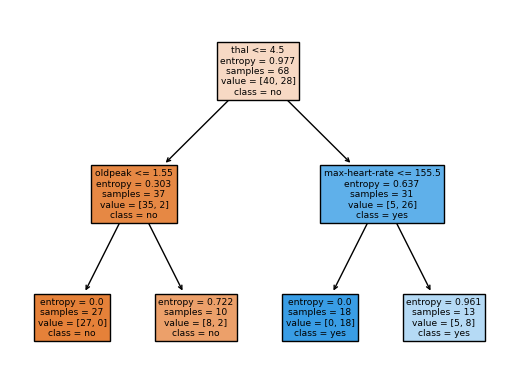

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10,
                            min_samples_leaf=10).fit(x_test, predict)
tree.plot_tree(dt, feature_names=X.columns, filled=True,
               class_names=['no', "yes"])

### **Feature Importance**

A partir do acrescimo de erros que o modelo passa a ter quando nós permutamos o valor da feature, é exibido quais são as features mais importantes, no qual se os erros aumentarem depois de embaralhar os valores da feature, então a feature é importante.

> Este modelo possui sua explicabilidade limitada, uma vez que o mesmo mede o efeito individual de cada feature na previsão, ignorando o efeito combinado das mesmas.

**Características**

- Real
- Tanto ante-hoc quanto Post-hoc
- Global

Perceba que no caso abaixo estamos fazendo a permutação com o modelo já treinado (post-hoc) encima dos dados de teste. Quanto maior o erro causado pela pertubação, maior é a importância da feature.

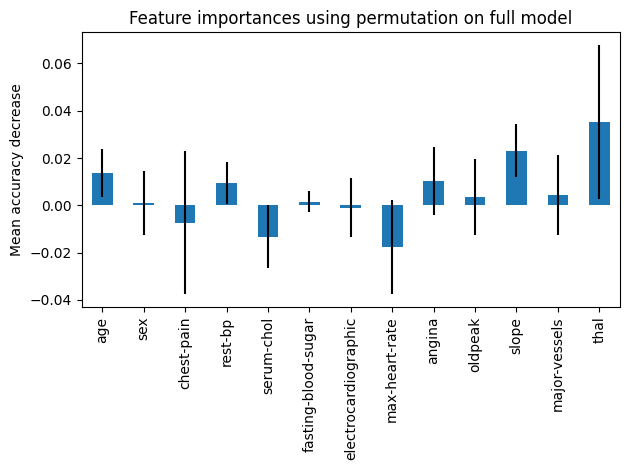

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

result = permutation_importance(rf, x_test, y_test, n_repeats=30,
                                random_state=0)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### **Particial Dependence Plots (PDP)**

Mostra como a previsão de um modelo varia, à medida que se varia o valor de um ou mais atributos, da seguinte forma:
1. Para cada feature, é criada novas instâncias variando o valor do atributo de interesse e fixando as demais variáveis.
2. As instâncias criadas são fornecidas como entrada para o modelo e as previsão são calculadas.
3. Para cada variação, é devolvido a previsão média retornada pelo modelo.

> Ele assume que as features não estão correlacionadas. Quanto maior o PDP, maior a chance de dar positivo a análise em questão (Y).

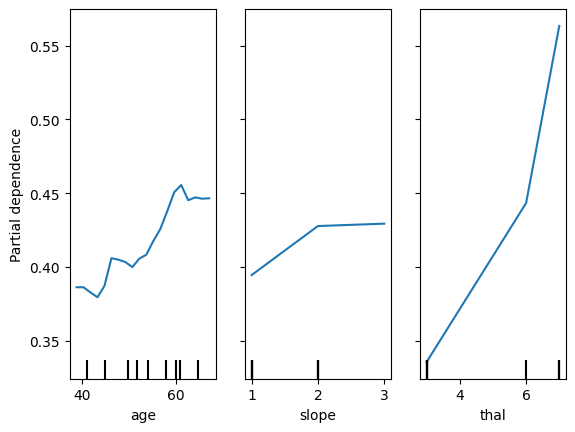

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

FEATURE_IDX = [0, 10, 12]

PartialDependenceDisplay.from_estimator(rf, x_test, FEATURE_IDX,
                                        grid_resolution=20)

**Características**:
- Aproximado
- Post-hoc
- Global

Essa técnica necessita analisa apenas a relação de uma feature em específico, ou seja, é aconselhado que você queira utilizar ela apenas quando sabe que é útil para análise (por exemplo, através do Feature Importance). Assim você pode ver como essa feature se comporta com a variação, exemplo:
> Qual a chance de um ataque cardiaco a partir da idade?

Abaixo se encontra um exemplo para o KNN (2D):


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


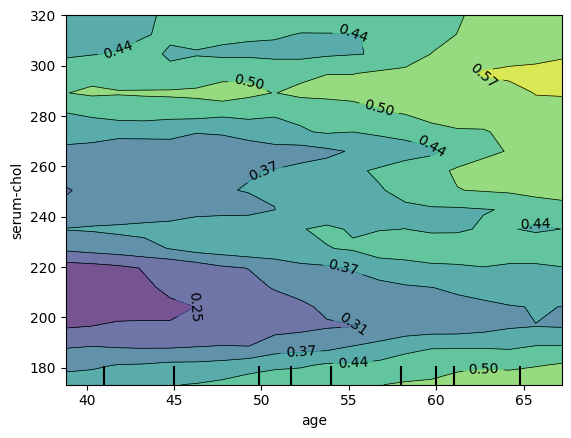

In [ ]:
FEATURE_IDX = (0, 4)

PartialDependenceDisplay.from_estimator(knn, x_test, [FEATURE_IDX],
                                        grid_resolution=20)

### **Individual Conditional Expectation (ICE)**

A mesma lógica que o PDP, porém o gráfico mostra a variação de cada uma das instâncias (ou seja, a mediana é justamente o PDP).

> Assim como a análise anterior, é possível rodar com mais de uma análise, mas considerando que o algoritmo é executado individualmente para cada análise, a utilização do ICE costuma ser mais individual ainda.

**Características**:
- Aproximado
- Post-hoc
- Local e Global

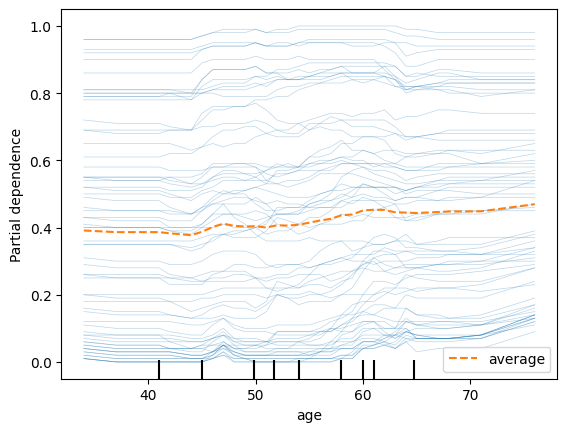

In [ ]:
FEATURE_IDX = [0]

PartialDependenceDisplay.from_estimator(rf, x_test, FEATURE_IDX, kind='both')

### **Local Surrogate (LIME)**

Serve para analisar uma instância individual a partir da "vizinhança" dessa instância em um modelo mais simples, da seguinte forma:
1. É gerado novas instâncias artificiais a partir da instância a ser explicada (com valores próximos).
2. Fornece essas instâncais como entrada para o modelo e coleta as predições.
3. A partir das predições, é treinado um novo modelo que explica elas (assim como o Global Surrogate).

> Ou seja, a diferença para o Global Surrogate é que as instâncias não vem do resultado de um modelo, mas sim da redondeza de uma instância (porque você quer explicar essa instância e não um outro modelo).

**Características**:
- Aproximado
- Post-hoc
- Local e Global

In [ ]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(x_train.values,
                                              feature_names= x_train.columns,
                                              class_names= ["yes","no"],
                                              discretize_continuous=False)

# Chosing the first instance to see the explanation for it
index = 0
instance = x_test.iloc[index,:]
instance

age                      58.0
sex                       1.0
chest-pain                4.0
rest-bp                 146.0
serum-chol              218.0
fasting-blood-sugar       0.0
electrocardiographic      0.0
max-heart-rate          105.0
angina                    0.0
oldpeak                   2.0
slope                     2.0
major-vessels             1.0
thal                      7.0
Name: 80, dtype: float64

Abaixo mostra a explicação da primeira instância do dataset de teste, no qual mostra (1) a probabilidade para cada classe (2) as N features mais importantes para cada uma dessas probabilidades e (3) o valor dessas features para essa instância.

In [ ]:
exp = explainer.explain_instance(instance, rf.predict_proba,
                                 num_features=5, top_labels=1)

exp.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
